# Understanding Transformers from Scratch

A practical guide to building and understanding the transformer architecture.

**Note:** Throughout this post, we use word-level tokenization (1 token = 1 word) for clarity. In practice, models use subword tokenization (BPE, WordPiece, etc.).

## Step 1: The Data

Let's start with a simple sentence and understand how we turn text into numbers.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Example text
text = "A fluffy blue creature roamed the verdant forest"
tokens = text.split()

print(f"Text: {text}")
print(f"Tokens: {tokens}")
print(f"Number of tokens: {len(tokens)}")

# Create a simple vocabulary
vocab = sorted(set(tokens))
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for word, i in word_to_idx.items()}

print(f"\nVocabulary: {vocab}")
print(f"Word to index mapping: {word_to_idx}")

# Encode our text
encoded = [word_to_idx[word] for word in tokens]
print(f"\nEncoded: {encoded}")

Text: A fluffy blue creature roamed the verdant forest
Tokens: ['A', 'fluffy', 'blue', 'creature', 'roamed', 'the', 'verdant', 'forest']
Number of tokens: 8

Vocabulary: ['A', 'blue', 'creature', 'fluffy', 'forest', 'roamed', 'the', 'verdant']
Word to index mapping: {'A': 0, 'blue': 1, 'creature': 2, 'fluffy': 3, 'forest': 4, 'roamed': 5, 'the': 6, 'verdant': 7}

Encoded: [0, 3, 1, 2, 5, 6, 7, 4]


## Step 2: Embeddings

We represent each word as a vector of numbers (embedding). We also need position embeddings since word order matters.

In [2]:
# Hyperparameters
vocab_size = len(vocab)
n_embed = 8  # Small for visualization
block_size = len(tokens)

# Create embedding tables
token_embedding = nn.Embedding(vocab_size, n_embed)
position_embedding = nn.Embedding(block_size, n_embed)

# Get embeddings
idx = torch.tensor(encoded).unsqueeze(0)  # (1, T)
tok_emb = token_embedding(idx)  # (1, T, C)
pos_emb = position_embedding(torch.arange(len(tokens)))  # (T, C)

# Combine
x = tok_emb + pos_emb

print(f"Token embeddings shape: {tok_emb.shape}")
print(f"Position embeddings shape: {pos_emb.shape}")
print(f"Combined embeddings shape: {x.shape}")
print(f"\nEmbedding for 'creature':\n{x[0, 3, :]}")

Token embeddings shape: torch.Size([1, 8, 8])
Position embeddings shape: torch.Size([8, 8])
Combined embeddings shape: torch.Size([1, 8, 8])

Embedding for 'creature':
tensor([-2.0043,  1.4715, -1.2445,  0.9710,  0.3426, -0.3353, -2.0724,  1.2203],
       grad_fn=<SliceBackward0>)


## Step 3: Attention - The Core Idea

Attention lets each token look at previous tokens and gather relevant information.

**Query (Q):** What am I looking for?
**Key (K):** What do I have to offer?
**Value (V):** My actual content

The attention formula:
$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

Attention output shape: torch.Size([1, 8, 4])
Attention weights shape: torch.Size([1, 8, 8])


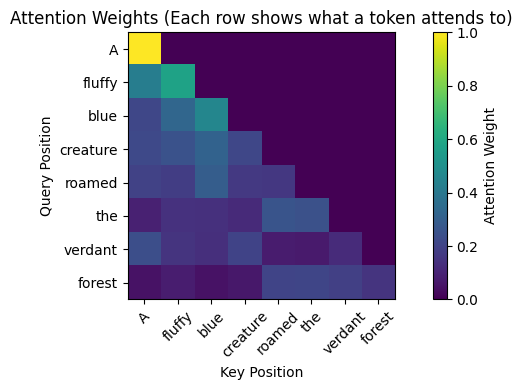

In [3]:
class SingleHeadAttention(nn.Module):
    def __init__(self, n_embed, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)    # (B, T, head_size)
        q = self.query(x)  # (B, T, head_size)
        v = self.value(x)  # (B, T, head_size)

        # Compute attention scores
        wei = q @ k.transpose(-2, -1) * C**-0.5  # (B, T, T)

        # Mask future positions (causal attention)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))

        # Normalize to probabilities
        wei = F.softmax(wei, dim=-1)

        # Weighted sum of values
        out = wei @ v
        return out, wei

# Test single head attention
head = SingleHeadAttention(n_embed, head_size=4)
attended, attention_weights = head(x)

print(f"Attention output shape: {attended.shape}")
print(f"Attention weights shape: {attention_weights.shape}")

# Visualize attention weights for position 3 (creature)
plt.figure(figsize=(8, 4))
plt.imshow(attention_weights[0].detach().numpy(), cmap='viridis')
plt.colorbar(label='Attention Weight')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.xticks(range(len(tokens)), tokens, rotation=45)
plt.yticks(range(len(tokens)), tokens)
plt.title('Attention Weights (Each row shows what a token attends to)')
plt.tight_layout()
plt.show()

## Step 4: Multi-Head Attention

Instead of asking one question, we ask multiple questions in parallel. Each "head" can specialize in different patterns:

- Head 1: "Were there adjectives before me?"
- Head 2: "What's the verb?"
- Head 3: "What's my role in the sentence?"
- Head 4: "What's the article/determiner?"

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, n_embed):
        super().__init__()
        self.heads = nn.ModuleList([SingleHeadAttention(n_embed, head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embed)

    def forward(self, x):
        # Run all heads in parallel and concatenate
        out = torch.cat([h(x)[0] for h in self.heads], dim=-1)
        out = self.proj(out)
        return out

# Test multi-head attention
mha = MultiHeadAttention(num_heads=4, head_size=2, n_embed=n_embed)
mha_out = mha(x)

print(f"Multi-head attention output shape: {mha_out.shape}")

Multi-head attention output shape: torch.Size([1, 8, 8])


## Step 5: Feed-Forward Network

After tokens communicate (attention), each token needs to "think" individually about what it learned.

In [5]:
class FeedForward(nn.Module):
    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, 4 * n_embed),
            nn.ReLU(),
            nn.Linear(4 * n_embed, n_embed),
        )

    def forward(self, x):
        return self.net(x)

ffn = FeedForward(n_embed)
ffn_out = ffn(mha_out)

print(f"Feed-forward output shape: {ffn_out.shape}")

Feed-forward output shape: torch.Size([1, 8, 8])


## Step 6: The Transformer Block

Combine attention and feed-forward with residual connections:

1. Multi-head attention (communication)
2. Add & Norm (residual connection)
3. Feed-forward (thinking)
4. Add & Norm (residual connection)

In [6]:
class TransformerBlock(nn.Module):
    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size, n_embed)
        self.ffwd = FeedForward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        # Attention with residual
        x = x + self.sa(self.ln1(x))
        # Feed-forward with residual
        x = x + self.ffwd(self.ln2(x))
        return x

block = TransformerBlock(n_embed=n_embed, n_head=4)
block_out = block(x)

print(f"Transformer block output shape: {block_out.shape}")

Transformer block output shape: torch.Size([1, 8, 8])


## Step 7: The Complete Model

Stack multiple transformer blocks and add an output projection to predict the next token.

In [7]:
class SimpleTransformer(nn.Module):
    def __init__(self, vocab_size, n_embed, n_head, n_layer, block_size):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_embed)
        self.position_embedding = nn.Embedding(block_size, n_embed)
        self.blocks = nn.Sequential(*[TransformerBlock(n_embed, n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)

    def forward(self, idx):
        B, T = idx.shape

        # Embeddings
        tok_emb = self.token_embedding(idx)
        pos_emb = self.position_embedding(torch.arange(T))
        x = tok_emb + pos_emb

        # Transformer blocks
        x = self.blocks(x)
        x = self.ln_f(x)

        # Output projection
        logits = self.lm_head(x)
        return logits

# Create model
model = SimpleTransformer(
    vocab_size=vocab_size,
    n_embed=8,
    n_head=4,
    n_layer=2,
    block_size=block_size
)

# Forward pass
logits = model(idx)
print(f"Logits shape: {logits.shape}")
print(f"Logits represent scores for {vocab_size} possible next words at each of {len(tokens)} positions")

Logits shape: torch.Size([1, 8, 8])
Logits represent scores for 8 possible next words at each of 8 positions


## Step 8: Understanding the Output

The model outputs "logits" - unnormalized scores for each possible next word. We convert these to probabilities using softmax.

In [8]:
# Get predictions for the last position
last_logits = logits[0, -1, :]  # (vocab_size,)
probs = F.softmax(last_logits, dim=-1)

# Show predictions
print("After seeing: 'A fluffy blue creature roamed the verdant forest'")
print("\nTop 3 predicted next words:")
top_probs, top_indices = torch.topk(probs, 3)
for prob, idx in zip(top_probs, top_indices):
    word = idx_to_word[idx.item()]
    print(f"  {word}: {prob.item():.2%}")

After seeing: 'A fluffy blue creature roamed the verdant forest'

Top 3 predicted next words:
  verdant: 21.19%
  blue: 15.73%
  roamed: 15.40%


## Summary: Information Flow Through the Transformer

Let's trace what happens to the word "creature" (position 3):

1. **Initial Embedding:** "I'm the word 'creature' at position 3"

2. **Block 1 - Attention:** Looks back and gathers info
   - Head 1 finds: "fluffy" and "blue" (adjectives)
   - Head 2 finds: "A" (article)
   - Result: "I'm a fluffy blue creature"

3. **Block 1 - Feed-Forward:** Processes the information
   - "I'm a noun phrase"

4. **Block 2 - Attention:** Deeper understanding
   - Finds relationship with "roamed"
   - Result: "I'm the subject of 'roamed'"

5. **Block 2 - Feed-Forward:** Final refinement
   - "Complete noun phrase, subject of verb"

6. **Output:** Predicts what comes next based on all this context

## Key Takeaways

The transformer architecture consists of three main components:

- **Self-Attention:** Tokens communicate and gather context from previous tokens
- **Feed-Forward:** Each token processes its gathered information independently
- **Residual Connections:** Information flows through the network without getting lost

Each layer builds richer, more abstract representations:
- Early layers: syntax and word relationships
- Middle layers: phrase structure and grammatical roles
- Later layers: semantic meaning and long-range dependencies

This is the foundation of modern language models like GPT, BERT, and beyond!